In [1]:
#This python script (done in Jupyer notebook) was created by Marc Elliott
#The purpose of this script is to prepare the Open University Learning Analytics dataset
#This handles wrangling and merging datasets, handling missing values, as well as feature mining
#and normalisation of the dataset
#Additionally - some class distrubutions have been explored and SMOTE had been trialed for resampling
#See note on SMOTE tab for more info.

#The purpose for using this dataset is to predict the 'final_result' feature to determine
#whether a student will pass or fail their course (primarily through VLE feature data)


### Install any packages we will need for data preprocessing and analysis
%pip install pandas
%pip install numpy
%pip install scikit-learn
%pip install imblearn
%pip install matplotlib

In [2]:
#Suppress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Add the packages
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import zscore

In [3]:
#LOAD ALL DATA FILES
ass = pd.read_csv('data/assessments.csv')
courses = pd.read_csv('data/courses.csv')
results = pd.read_csv('data/studentAssessment.csv')
info = pd.read_csv('data/studentInfo.csv')
reg = pd.read_csv('data/studentRegistration.csv')
vle = pd.read_csv('data/studentVle.csv')
materials = pd.read_csv('data/vle.csv')

In [4]:
#CLEAN DATA
#MERGING DATA FILES

#Convert ID'S to categorical
ass['id_assessment'] = ass['id_assessment'].astype(object)
results['id_assessment'] = results['id_assessment'].astype(object)
results['id_student'] = results['id_student'].astype(object)
reg['id_student'] = reg['id_student'].astype(object)
materials['id_site'] = materials['id_site'].astype(object)
info['id_student'] = info['id_student'].astype(object)
vle['id_student'] = vle['id_student'].astype(object)
vle['id_site'] = vle['id_site'].astype(object)

#Fix inconsistent assessment weightings
# Assign new weights to module GGG assessments
ass.loc[(ass.code_module=='GGG') & (ass.assessment_type=='TMA'),'weight'] = (100/3)
ass.loc[(ass.code_module=='GGG') & (ass.assessment_type=='CMA'),'weight'] = (0)

#Null scores assumes student failed to submit assessment - we will replace these with the score 0
results.fillna(0, inplace=True)


In [5]:
#MINE AND MERGE FEATURE VALUES

#MERGE VLE AND MATERIALS
VLEmaterials = pd.merge(vle, materials, on=['code_module', 'code_presentation', 'id_site'], how='inner')
VLEmaterials.drop(columns=['week_from', 'week_to'], inplace=True)

#DERIVING NEW FEATURES
#Add features for the total number of clicks which students have before the course started and after course starts
total_click_before_course_start =  VLEmaterials[VLEmaterials['date'] < 1]\
.groupby(['code_module', 'code_presentation', 'id_student',])\
.agg(total_click_bc = ("sum_click",sum))\
.reset_index()

#bc = before course
#ac = after/during course
#Get total number of clicks from student after course starts
total_click_after_course_start = VLEmaterials[VLEmaterials['date'] >= 1]\
.groupby(['code_module', 'code_presentation', 'id_student'])\
.agg(total_click_ac = ("sum_click",sum))\
.reset_index()

#Get total click per student per module
total_click_per_student = VLEmaterials\
.groupby(['code_module', 'code_presentation', 'id_student'])\
.agg(total_click = ("sum_click",sum))\
.reset_index()

VLEmaterials.drop(columns=['date'],inplace=True)

In [6]:
#GET STUDENT NUMBER OF CLICKS FOR VARIOUS ACTIVITIES
#Uses click data from different aspects of the virtual learning environment
forumng_clicks_ps = VLEmaterials[VLEmaterials['activity_type']=='forumng']\
.groupby(['code_module', 'code_presentation','id_student','activity_type'])\
.agg(formng_clicks = ("sum_click",sum))\
.reset_index()
forumng_clicks_ps.drop(columns=['activity_type'],inplace=True)

oucontent_clicks_ps = VLEmaterials[VLEmaterials['activity_type']=='oucontent']\
.groupby(['code_module', 'code_presentation','id_student','activity_type'])\
.agg(oucontent_clicks = ("sum_click",sum))\
.reset_index()
oucontent_clicks_ps.drop(columns=['activity_type'],inplace=True)

homepage_clicks_ps = VLEmaterials[VLEmaterials['activity_type']=='homepage']\
.groupby(['code_module', 'code_presentation','id_student','activity_type'])\
.agg(homepage_clicks = ("sum_click",sum))\
.reset_index()
homepage_clicks_ps.drop(columns=['activity_type'],inplace=True)

quiz_clicks_ps = VLEmaterials[VLEmaterials['activity_type']=='quiz']\
.groupby(['code_module', 'code_presentation','id_student','activity_type'])\
.agg(quiz_clicks = ("sum_click",sum))\
.reset_index()
quiz_clicks_ps.drop(columns=['activity_type'],inplace=True)


subpage_clicks_ps = VLEmaterials[VLEmaterials['activity_type']=='subpage']\
.groupby(['code_module', 'code_presentation','id_student','activity_type'])\
.agg(subpage_clicks = ("sum_click",sum))\
.reset_index()
subpage_clicks_ps.drop(columns=['activity_type'],inplace=True)


resource_clicks_ps = VLEmaterials[VLEmaterials['activity_type']=='resource']\
.groupby(['code_module', 'code_presentation','id_student','activity_type'])\
.agg(resource_clicks = ("sum_click",sum))\
.reset_index()
resource_clicks_ps.drop(columns=['activity_type'],inplace=True)


url_clicks_ps = VLEmaterials[VLEmaterials['activity_type']=='url']\
.groupby(['code_module', 'code_presentation','id_student','activity_type'])\
.agg(url_clicks = ("sum_click",sum))\
.reset_index()
url_clicks_ps.drop(columns=['activity_type'],inplace=True)


ouwiki_clicks_ps = VLEmaterials[VLEmaterials['activity_type']=='ouwiki']\
.groupby(['code_module', 'code_presentation','id_student','activity_type'])\
.agg(ouwiki_clicks = ("sum_click",sum))\
.reset_index()
ouwiki_clicks_ps.drop(columns=['activity_type'],inplace=True)


questionnaire_clicks_ps = VLEmaterials[VLEmaterials['activity_type']=='questionnaire']\
.groupby(['code_module', 'code_presentation','id_student','activity_type'])\
.agg(questionnaire_clicks = ("sum_click",sum))\
.reset_index()
questionnaire_clicks_ps.drop(columns=['activity_type'],inplace=True)


glossary_clicks_ps = VLEmaterials[VLEmaterials['activity_type']=='glossary']\
.groupby(['code_module', 'code_presentation','id_student','activity_type'])\
.agg(glossary_clicks = ("sum_click",sum))\
.reset_index()
glossary_clicks_ps.drop(columns=['activity_type'],inplace=True)

#DROP REDUNDANT COLUMNS
VLEmaterials.drop(columns=['activity_type','id_site','sum_click'],inplace=True)

In [7]:
#MERGE FEATURES TO SINGLE DATAFRAME
VLEmaterials_merge = pd.merge(VLEmaterials, forumng_clicks_ps, on=['id_student', 'code_module', 'code_presentation'], how='left')
VLEmaterials_merge = pd.merge(VLEmaterials_merge, oucontent_clicks_ps, on=['id_student', 'code_module', 'code_presentation'], how='left')
VLEmaterials_merge = pd.merge(VLEmaterials_merge, homepage_clicks_ps, on=['id_student', 'code_module', 'code_presentation'], how='left')
VLEmaterials_merge = pd.merge(VLEmaterials_merge, quiz_clicks_ps, on=['id_student', 'code_module', 'code_presentation'], how='left')
VLEmaterials_merge = pd.merge(VLEmaterials_merge, subpage_clicks_ps, on=['id_student', 'code_module', 'code_presentation'], how='left')
VLEmaterials_merge = pd.merge(VLEmaterials_merge, resource_clicks_ps, on=['id_student', 'code_module', 'code_presentation'], how='left')
VLEmaterials_merge = pd.merge(VLEmaterials_merge, url_clicks_ps, on=['id_student', 'code_module', 'code_presentation'], how='left')
VLEmaterials_merge = pd.merge(VLEmaterials_merge, ouwiki_clicks_ps, on=['id_student', 'code_module', 'code_presentation'], how='left')
VLEmaterials_merge = pd.merge(VLEmaterials_merge, questionnaire_clicks_ps, on=['id_student', 'code_module', 'code_presentation'], how='left')
VLEmaterials_merge = pd.merge(VLEmaterials_merge, glossary_clicks_ps, on=['id_student', 'code_module', 'code_presentation'], how='left')
VLEmaterials_merge = pd.merge(VLEmaterials_merge, total_click_before_course_start, on=['id_student', 'code_module', 'code_presentation'], how='left')
VLEmaterials_merge = pd.merge(VLEmaterials_merge, total_click_after_course_start, on=['id_student', 'code_module', 'code_presentation'], how='left')
VLEmaterials_merge = pd.merge(VLEmaterials_merge, total_click_per_student, on=['id_student', 'code_module', 'code_presentation'], how='left')

#DROP ANY DUPLICATES THAT MAY HAVE BEEN MERGED
VLEmaterials_merge = VLEmaterials_merge.drop_duplicates()

In [8]:
#MERGE REMAINING DATASETS INTO SINGLE DATADFRAME
regCourses = pd.merge(reg, courses, on=['code_module', 'code_presentation'], how='inner')
regCoursesInfo = pd.merge(regCourses, info, on=['code_module', 'code_presentation', 'id_student'], how='inner')
assResults = pd.merge(ass, results, on=['id_assessment'], how='inner')

In [9]:
#OBTAIN STUDENT ASSIGNMENT SUBMISSION VALUES

#Used to sum number of submissions for each type of assessment per student
assResults['submission_count'] = 1

total_assessments_ps =  assResults\
.groupby(['code_module', 'code_presentation', 'id_student',])\
.agg(total_assessment_submissions = ("submission_count",sum))\
.reset_index()

total_TMA_ps =  assResults[assResults['assessment_type'] == 'TMA']\
.groupby(['code_module', 'code_presentation', 'id_student',])\
.agg(total_TMA_submissions = ("submission_count",sum))\
.reset_index()

total_CMA_ps =  assResults[assResults['assessment_type'] == 'CMA']\
.groupby(['code_module', 'code_presentation', 'id_student',])\
.agg(total_CMA_submissions = ("submission_count",sum))\
.reset_index()

total_Exam_ps =  assResults[assResults['assessment_type'] == 'Exam']\
.groupby(['code_module', 'code_presentation', 'id_student',])\
.agg(total_Exam_submissions = ("submission_count",sum))\
.reset_index()

In [10]:
#GET LATE SUBMISSION INFORMATION
lateSubmission = assResults.assign(submission_days=assResults['date_submitted']-assResults['date'])
lateSubmission = lateSubmission.assign(late_submission=lateSubmission['submission_days'] > 0)

total_late_per_student = lateSubmission\
.groupby(['id_student', 'code_module', 'code_presentation'])\
.agg(total_late_submission = ('late_submission', sum))\
.reset_index()

total_count_assessments = lateSubmission[['id_student', 'code_module', 'code_presentation', 'id_assessment']]\
.groupby(['id_student', 'code_module', 'code_presentation'])\
.size()\
.reset_index(name='total_assessments')

late_rate_per_student = pd.merge(total_late_per_student, total_count_assessments, on=['id_student', 'code_module', 'code_presentation'], how='inner')
late_rate_per_student['late_rate'] = late_rate_per_student['total_late_submission'] / late_rate_per_student['total_assessments']
late_rate_per_student.drop(columns=['total_late_submission','total_assessments'], inplace=True)

In [11]:
#MERGE ALL ASSESSMENT TYPE SUBMISSION INFORMATION AND STUDENT LATE SUBMISSION RATE TO SINGLE DATAFRAME
assResults_merge = pd.merge(assResults, total_assessments_ps, on=['id_student', 'code_module', 'code_presentation'], how='left')
assResults_merge = pd.merge(assResults_merge, total_TMA_ps, on=['id_student', 'code_module', 'code_presentation'], how='left')
assResults_merge = pd.merge(assResults_merge, total_CMA_ps, on=['id_student', 'code_module', 'code_presentation'], how='left')
assResults_merge = pd.merge(assResults_merge, total_Exam_ps, on=['id_student', 'code_module', 'code_presentation'], how='left')
assResults_merge = pd.merge(assResults_merge, late_rate_per_student, on=['id_student', 'code_module', 'code_presentation'], how='left')
assResults_merge.drop(columns=['date', 'weight','date_submitted','is_banked','score','assessment_type','submission_count'], inplace=True)
assResults_merge = assResults_merge.drop_duplicates()

In [12]:
#MERGE AND CLEAN ALL DATA INTO ONE DATAFRAME
merged = pd.merge(regCoursesInfo, VLEmaterials_merge, on=['id_student', 'code_module', 'code_presentation'], how='left')
merged = pd.merge(merged, assResults_merge, on=['id_student', 'code_module', 'code_presentation'], how='left')
merged.drop(columns=['date_unregistration', 'code_module','code_presentation','id_student','id_assessment'], inplace=True)
merged = merged.drop_duplicates()
merged.drop(columns=['imd_band','region'],inplace=True)

In [13]:
#CLEAN VALUES

#REPLACE MISSING CLICK VALUES WITH 0 -
#Missing values means that there has been no student interaction - thus zero is inserted.
merged['total_click'] = merged['total_click'].replace(np.nan).fillna(0)
merged['total_click_ac'] = merged['total_click_ac'].replace(np.nan).fillna(0)
merged['total_click_bc'] = merged['total_click_bc'].replace(np.nan).fillna(0)
merged['formng_clicks'] = merged['formng_clicks'].replace(np.nan).fillna(0)
merged['oucontent_clicks'] = merged['oucontent_clicks'].replace(np.nan).fillna(0)
merged['homepage_clicks'] = merged['homepage_clicks'].replace(np.nan).fillna(0)
merged['quiz_clicks'] = merged['quiz_clicks'].replace(np.nan).fillna(0)
merged['subpage_clicks'] = merged['subpage_clicks'].replace(np.nan).fillna(0)
merged['resource_clicks'] = merged['resource_clicks'].replace(np.nan).fillna(0)
merged['url_clicks'] = merged['url_clicks'].replace(np.nan).fillna(0)
merged['ouwiki_clicks'] = merged['ouwiki_clicks'].replace(np.nan).fillna(0)
merged['questionnaire_clicks'] = merged['questionnaire_clicks'].replace(np.nan).fillna(0)
merged['glossary_clicks'] = merged['glossary_clicks'].replace(np.nan).fillna(0)

#MISSING LATE RATE - NO SUBMISSIONS - 100% LATE RATE
merged['late_rate'] = merged['late_rate'].replace(np.nan).fillna(1.0)

#MISSING ASSESSMENT SUBMISSIONS - THOSE ASSUMED TO HAVE NO SUBMISSIONS - 0
merged['total_assessment_submissions'] = merged['total_assessment_submissions'].replace(np.nan).fillna(0)
merged['total_TMA_submissions'] = merged['total_TMA_submissions'].replace(np.nan).fillna(0)
merged['total_CMA_submissions'] = merged['total_CMA_submissions'].replace(np.nan).fillna(0)
merged['total_Exam_submissions'] = merged['total_Exam_submissions'].replace(np.nan).fillna(0)

In [14]:
#DROP WITHDRAWN STUDENTS
merged = merged[merged.final_result != 'Withdrawn']

#TARGET PREDICTION CLASS CLEAN - PASS OR FAIL
#The purpose of our data is to predict whether the final result of a student enrolled on an Open University Module
#will pass or fail their module - as represented by the 'final_result' feature.
merged['final_result'] = np.where( (merged['final_result'] == 'Distinction'),'Pass', merged['final_result'] )
#merged['final_result'] = np.where( (merged['final_result'] == 'Withdrawn'),'Fail', merged['final_result'] )
merged["final_result"].replace({'Fail':0,'Pass':1},inplace=True)

In [15]:
#SENSITIVE ATTRIBUTES - ENCODING & ORDINAL ENCODING

#Dichotomization for Disability and Gender - whether they have a disability, and whether they are male or female
#DISABILITY - HAS DISABILITY =1. NO DISABILITY = 0
merged["disability"].replace({'N':0,'Y':1},inplace=True)

#GENDER - MALE = 1, NOT MALE (FEMALE) = 0
merged["gender"].replace({'M':1,'F':0},inplace=True)


#Discretization - Representing age within age bands.
#AGE BAND - ORDINAL ENCODE BY AGE BAND INCREASING
merged["age_band"].replace({'0-35':0,'35-55':1,'55<=':2},inplace=True)

#HIGHEST EDUCATION - ORDINAL ENCODE FROM LOWEST TO HIGHEST
merged["highest_education"].replace({'No Formal quals':0,'Lower Than A Level':1,'A Level or Equivalent':2, 'HE Qualification':3,'Post Graduate Qualification':4},inplace=True)


In [16]:
merged.head()

,date_registration,module_presentation_length,gender,highest_education,age_band,num_of_prev_attempts,studied_credits,disability,final_result,formng_clicks,...,questionnaire_clicks,glossary_clicks,total_click_bc,total_click_ac,total_click,total_assessment_submissions,total_TMA_submissions,total_CMA_submissions,total_Exam_submissions,late_rate
0,-159.0,268,1,3,2,0,240,0,1,193.0,...,0.0,0.0,147.0,787.0,934.0,5.0,5.0,0.0,0.0,0.0
5,-53.0,268,0,3,1,0,60,0,1,417.0,...,0.0,0.0,263.0,1172.0,1435.0,5.0,5.0,0.0,0.0,0.4
11,-52.0,268,0,2,1,0,60,0,1,634.0,...,0.0,1.0,169.0,1989.0,2158.0,5.0,5.0,0.0,0.0,0.0
16,-176.0,268,0,1,0,0,60,0,1,194.0,...,0.0,4.0,295.0,739.0,1034.0,5.0,5.0,0.0,0.0,1.0
21,-110.0,268,1,2,1,0,60,0,1,875.0,...,0.0,4.0,325.0,2120.0,2445.0,5.0,5.0,0.0,0.0,0.2


In [17]:
#SPLIT DATA
#SKlearn train_test_split will be used to split data into training and test with a 70% train and 30% test split
from sklearn.model_selection import train_test_split
train, test = train_test_split(merged, test_size=0.3, random_state=1)

In [18]:
#HANDLING REMAINING MISSING VALUES
#Date Registration - REPLACE WITH MEDIAN
train['date_registration'] = np.where( (train['date_registration'].isnull()),train.date_registration.median(),train['date_registration'])
test['date_registration'] = np.where( (test['date_registration'].isnull()),test.date_registration.median(),test['date_registration'])
merged['date_registration'] = np.where( (merged['date_registration'].isnull()),merged.date_registration.median(),merged['date_registration'])

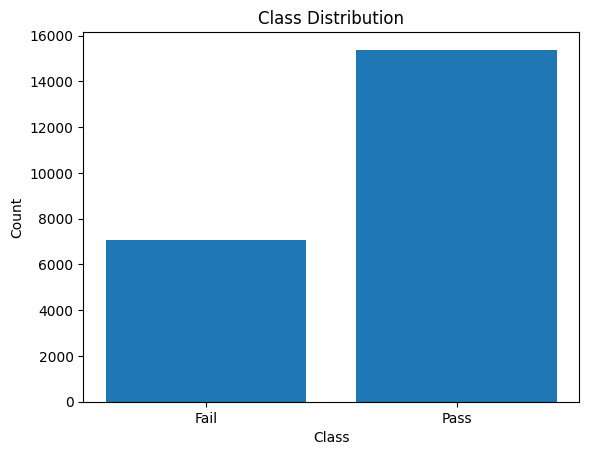

In [19]:
#CHECKING DATA DISTRIBUTIONS
#FULL DATASET
#15385 students pass their module
#7050 students fail their module
#Total students in cleaned dataset = 22,435
count_class_all = merged['final_result'].value_counts() # Count the occurrences of each class
plt.bar(count_class_all.index, count_class_all.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(count_class_all.index, ['Pass', 'Fail'])
plt.show()

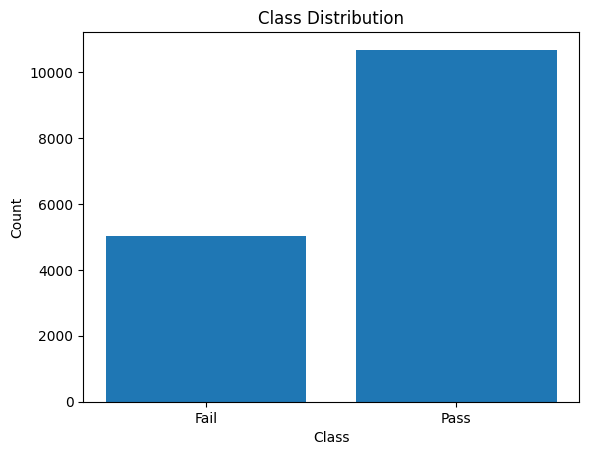

In [20]:
#Class distribution for training data
train['final_result'].value_counts()
count_class_train = train['final_result'].value_counts() # Count the occurrences of each class
plt.bar(count_class_train.index, count_class_train.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(count_class_train.index, ['Pass', 'Fail'])
plt.show()

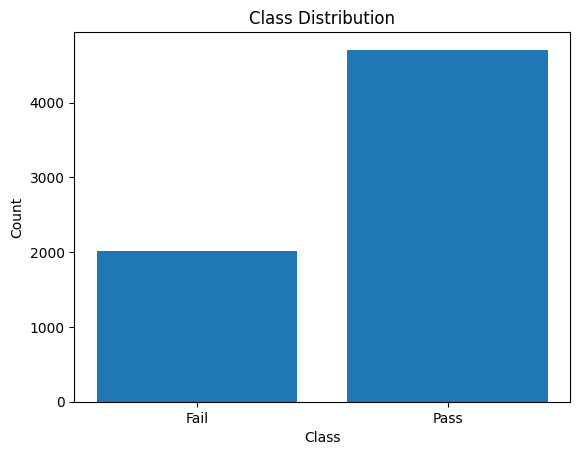

In [21]:
#Class distribution for test data
test['final_result'].value_counts()
count_class_test = test['final_result'].value_counts() # Count the occurrences of each class
plt.bar(count_class_test.index, count_class_test.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(count_class_test.index, ['Pass', 'Fail'])
plt.show()

In [22]:
#Uncomment to apply SMOTE to the training data to balance group distrubutions
#NOTE- this had been trialed but returned variable results, therefore, I have currently removed this from the final processed data
#...examining it would likely extend beyond the scope of this task. Could be introduced later in CI/CD if imbalanced group distributions
#show any signs of bias or performance issues in ML cycle

#smote=SMOTE(sampling_strategy='minority')
x=train.drop(["final_result"],axis=1)
y=train['final_result']
#x,y=smote.fit_resample(x,y)
y.value_counts()

,count
final_result,
1,10676
0,5028


In [23]:
train_balanced = x
train_balanced

,date_registration,module_presentation_length,gender,highest_education,age_band,num_of_prev_attempts,studied_credits,disability,formng_clicks,oucontent_clicks,...,questionnaire_clicks,glossary_clicks,total_click_bc,total_click_ac,total_click,total_assessment_submissions,total_TMA_submissions,total_CMA_submissions,total_Exam_submissions,late_rate
165101,-141.0,261,0,1,0,0,90,0,7.0,81.0,...,7.0,5.0,22.0,248.0,270.0,9.0,3.0,6.0,1.0,0.000000
172487,-8.0,241,0,1,0,0,90,0,61.0,87.0,...,7.0,8.0,93.0,273.0,366.0,8.0,3.0,5.0,1.0,0.250000
64232,-38.0,269,1,1,0,0,60,0,175.0,91.0,...,7.0,1.0,10.0,1044.0,1054.0,5.0,2.0,3.0,1.0,1.000000
140895,-25.0,241,1,1,0,0,90,0,313.0,924.0,...,3.0,1.0,235.0,2325.0,2560.0,12.0,5.0,7.0,1.0,0.000000
74758,-78.0,240,0,2,0,0,60,0,98.0,315.0,...,7.0,7.0,248.0,1056.0,1304.0,13.0,5.0,7.0,1.0,0.615385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88475,-57.0,241,1,1,0,0,60,0,731.0,46.0,...,7.0,416.0,100.0,1322.0,1422.0,7.0,6.0,7.0,1.0,0.142857
134087,-58.0,268,1,2,0,0,60,1,206.0,1254.0,...,7.0,28.0,128.0,2839.0,2967.0,12.0,5.0,7.0,1.0,0.083333
43161,-162.0,262,0,1,0,0,60,0,523.0,907.0,...,6.0,11.0,58.0,2200.0,2258.0,5.0,5.0,5.0,0.0,0.000000
96927,-151.0,262,1,1,0,0,60,0,61.0,143.0,...,7.0,2.0,2.0,284.0,286.0,7.0,6.0,7.0,1.0,0.000000


In [24]:
#Normalise numeric values using z-score
#Create dataframe of encoded features & drop encoded features before standardising data
train_gender = train_balanced['gender']
train_education = train_balanced['highest_education']
train_age = train_balanced['age_band']
train_disability = train_balanced['disability']
train_balanced_standardised = train_balanced.drop(['gender','highest_education','age_band','disability'],axis=1)
train_balanced_standardised_final = train_balanced_standardised.apply(zscore)

In [25]:
#Re-add the encoded and target feature column
train_balanced_standardised_final['gender'] = train_gender
train_balanced_standardised_final['highest_education'] = train_education
train_balanced_standardised_final['age_band'] = train_age
train_balanced_standardised_final['disability'] = train_disability
train_balanced_standardised_final['final_result'] = y
train_balanced_standardised_final

,date_registration,module_presentation_length,num_of_prev_attempts,studied_credits,formng_clicks,oucontent_clicks,homepage_clicks,quiz_clicks,subpage_clicks,resource_clicks,...,total_assessment_submissions,total_TMA_submissions,total_CMA_submissions,total_Exam_submissions,late_rate,gender,highest_education,age_band,disability,final_result
165101,-1.605058,0.375219,-0.327909,0.422336,-0.503011,-0.541866,-0.597741,-0.648753,-0.710152,-0.427299,...,0.409704,-0.878696,0.297273,0.613659,-0.932743,0,1,0,0,1
172487,1.213919,-1.144999,-0.327909,0.422336,-0.422262,-0.533454,-0.632597,-0.584916,-0.710152,-0.315726,...,0.125968,-0.878696,-0.234493,0.613659,-0.083440,0,1,0,0,1
64232,0.578060,0.983306,-0.327909,-0.388813,-0.251792,-0.527847,-0.452510,0.232991,-0.253232,-0.241345,...,-0.725238,-1.566654,-1.298025,0.613659,2.464467,1,1,0,0,0
140895,0.853599,-1.144999,-0.327909,0.422336,-0.045434,0.639950,0.134227,0.478363,0.403591,-0.055390,...,1.260910,0.497218,0.829039,0.613659,-0.932743,1,1,0,0,1
74758,-0.269753,-1.221010,-0.327909,-0.388813,-0.366934,-0.213817,0.238794,0.400563,0.786261,-0.042993,...,1.544645,0.497218,0.829039,0.613659,1.157848,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88475,0.175349,-1.144999,-0.327909,-0.388813,0.579622,-0.590933,-0.397321,0.400563,0.632050,-0.228948,...,-0.157767,1.185176,0.829039,0.613659,-0.447427,1,1,0,0,0
134087,0.154153,0.907295,-0.327909,-0.388813,-0.205437,1.102583,-0.074907,0.767623,1.140374,-0.228948,...,1.260910,0.497218,0.829039,0.613659,-0.649642,1,2,0,1,0
43161,-2.050160,0.451230,-0.327909,-0.388813,0.268589,0.616118,0.386931,-0.231820,-0.487403,-0.154566,...,-0.725238,0.497218,-0.234493,-1.629568,-0.932743,0,1,0,0,1
96927,-1.817011,0.451230,-0.327909,-0.388813,-0.422262,-0.454947,-0.600646,0.400563,-0.641614,-0.278536,...,-0.157767,1.185176,0.829039,0.613659,-0.932743,1,1,0,0,1


In [26]:
#Repeat for normalise for test data - MUST BE DONE SEPERATE AS TO NOT LEAK INFO
#Z-Score normalisation applied
test_gender = test['gender']
test_education = test['highest_education']
test_age = test['age_band']
test_disability = test['disability']
y_test = test['final_result']
test_standardised = test.drop(['gender','highest_education','age_band','disability','final_result'],axis=1)
test_standardised_final = test_standardised.apply(zscore)

#Re-add the encoded and target feature column
test_standardised_final['gender'] = test_gender
test_standardised_final['highest_education'] = test_education
test_standardised_final['age_band'] = test_age
test_standardised_final['disability'] = test_disability
test_standardised_final['final_result'] = y_test
test_standardised_final

,date_registration,module_presentation_length,num_of_prev_attempts,studied_credits,formng_clicks,oucontent_clicks,homepage_clicks,quiz_clicks,subpage_clicks,resource_clicks,...,total_assessment_submissions,total_TMA_submissions,total_CMA_submissions,total_Exam_submissions,late_rate,gender,highest_education,age_band,disability,final_result
23507,-0.184999,0.906416,-0.333398,-0.403883,-0.431172,-0.616494,-0.811712,-0.808180,-0.769091,-0.544582,...,-1.012426,-0.206125,-0.235817,-1.625520,-0.931768,0,1,1,0,0
29659,-1.488446,0.906416,-0.333398,2.068388,-0.481745,-0.655461,-0.731049,-0.764308,-0.708553,-0.495099,...,-1.295862,-1.594938,-2.356437,-1.625520,0.211052,0,2,1,1,0
87178,-0.814998,-1.142176,-0.333398,-0.403883,-0.383574,-0.604401,-0.437202,0.363014,-0.350828,0.432715,...,-1.862733,-2.289344,0.824493,0.615188,-0.931768,1,2,1,0,0
178095,-0.467412,0.982290,-0.333398,-1.227973,-0.453484,-0.470034,-0.610053,-0.581190,-0.675533,-0.321907,...,0.404752,-0.900531,0.294338,0.615188,-0.931768,1,2,0,0,0
124597,0.097415,0.906416,1.793715,2.068388,0.291721,2.414831,1.585155,0.691101,1.377261,0.049219,...,1.255058,0.488282,0.824493,0.615188,-0.360358,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119918,0.814311,-1.218050,-0.333398,-0.403883,0.792986,0.436945,0.308938,0.765493,0.408651,-0.074490,...,1.255058,0.488282,0.824493,0.615188,-0.646063,0,1,1,0,1
51287,0.944656,-1.142176,-0.333398,-1.227973,-0.386549,-0.229516,-0.169283,0.092152,0.403147,0.309007,...,0.404752,-0.206125,-0.765972,0.615188,0.591992,1,1,0,0,1
68184,0.944656,-1.218050,-0.333398,-0.403883,-0.206570,-0.499595,-0.183687,0.363014,-0.130689,0.358490,...,-0.162120,-0.206125,-1.826282,0.615188,0.047792,0,3,0,0,1
108903,1.053276,-1.218050,-0.333398,1.793691,-0.365725,0.982476,-0.215376,0.109319,0.045422,-0.099232,...,1.255058,0.488282,0.824493,0.615188,0.782462,0,1,0,1,1


In [28]:
#SAVE PREPROCESSED TRAINING AND TEST
train_balanced_standardised_final.to_csv('preprocessed_data/OULA_train_normalised.csv',index=False)
test_standardised_final.to_csv('preprocessed_data/OULA_test_normalised.csv',index=False)

train_balanced_standardised_final['final_result'].value_counts()
#Save full preprocessed not split dataset
merged.to_csv('preprocessed_data/OULA_full.csv',index=False)